<a href="https://colab.research.google.com/github/Blackan06/Blackan06/blob/main/WQI_PREDICT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score ,GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [110]:
url = '/content/CombineArea.xlsx'
df = pd.read_excel(url, header=0, index_col=0, parse_dates=True)

<ipython-input-110-2b2f7920713f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel(url, header=0, index_col=0, parse_dates=True)


In [111]:
df['pH_score'] = (df['PH'] - df['PH'].min()) / (df['PH'].max() - df['PH'].min()) * 100
df['DO_score'] = (df['DO'] - df['DO'].min()) / (df['DO'].max() - df['DO'].min()) * 100
df['Temperature_score'] = (df['Temperature'] - df['Temperature'].min()) / (df['Temperature'].max() - df['Temperature'].min()) * 100

# Tính WQI trung bình từ các yếu tố pH, DO và Temperature
df['WQI'] = ((df['pH_score'] + df['DO_score'] + df['Temperature_score']) / 3).round(2)

# Kiểm tra kết quả
print(df[['PH', 'DO', 'Temperature', 'WQI']].head())

      PH    DO  Temperature    WQI
NO                                
1   5.78  6.05         29.0  63.17
2   6.61  6.95         28.0  69.14
3   7.19  5.87         26.5  61.26
4   6.98  5.87         27.0  61.82
5   7.02  5.88         28.0  65.46


In [80]:
df.dtypes

,0
Area,object
Date,datetime64[ns]
Temperature,float64
PH,float64
DO,float64
pH_score,float64
DO_score,float64
Temperature_score,float64
WQI,float64


In [81]:
df.head()

,Area,Date,Temperature,PH,DO,pH_score,DO_score,Temperature_score,WQI
NO,,,,,,,,,
1,My Thuan,2003-01-15,29.0,5.78,6.05,61.783439,68.144499,59.595960,63.17
2,My Thuan,2003-02-15,28.0,6.61,6.95,75.000000,82.922824,49.494949,69.14
3,My Thuan,2003-03-15,26.5,7.19,5.87,84.235669,65.188834,34.343434,61.26
4,My Thuan,2003-04-15,27.0,6.98,5.87,80.891720,65.188834,39.393939,61.82
5,My Thuan,2003-05-15,28.0,7.02,5.88,81.528662,65.353038,49.494949,65.46


In [17]:
df.columns

Index(['Area', 'Date', 'Temperature', 'PH', 'DO', 'pH_score', 'DO_score',
       'Temperature_score', 'WQI'],
      dtype='object')

In [18]:
df['Date']

,Date
NO,
1,2003-01-15
2,2003-02-15
3,2003-03-15
4,2003-04-15
5,2003-05-15
...,...
744,2023-08-15
745,2023-09-15
746,2023-10-15


#Visualize the data


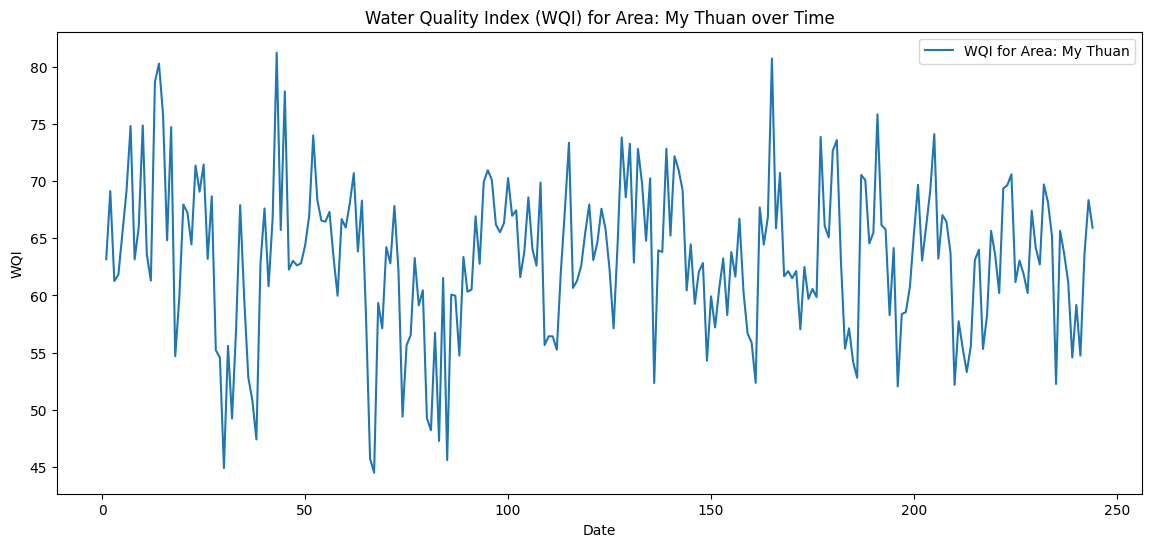

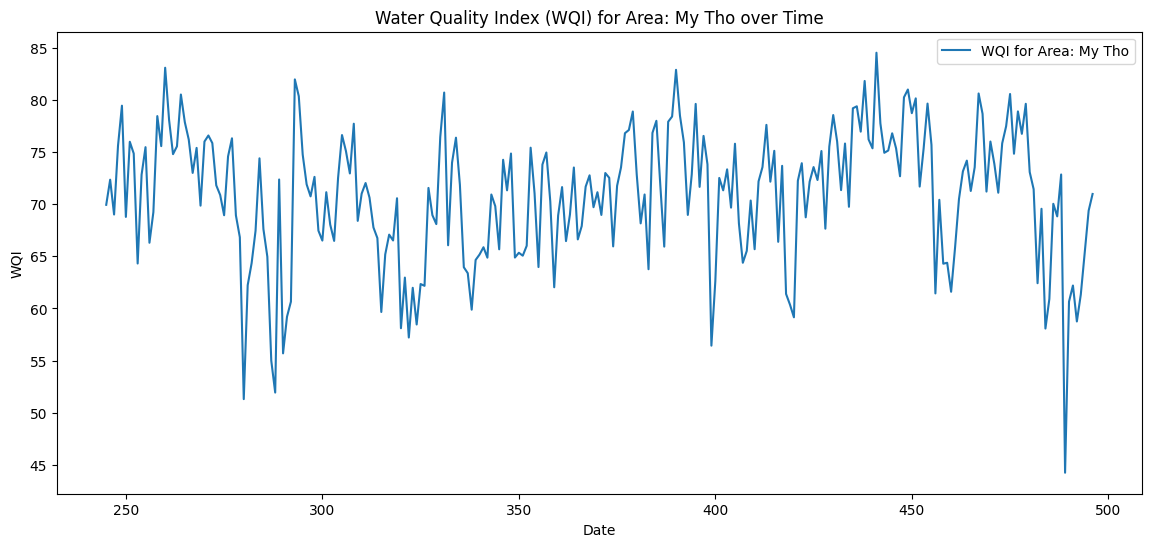

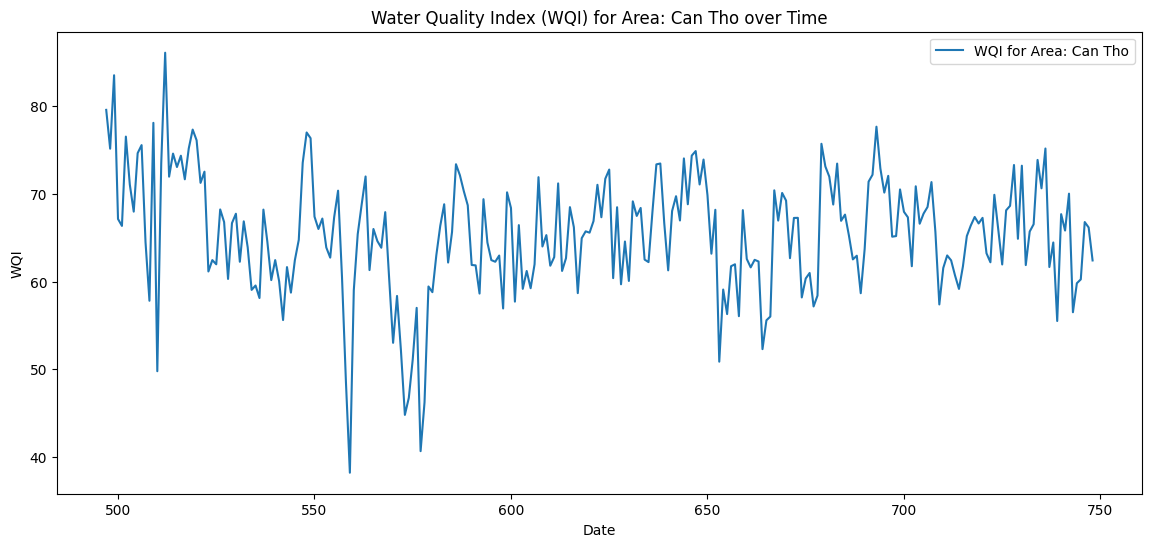

In [82]:
areas = df['Area'].unique()

# Lặp qua từng khu vực và vẽ line plot cho WQI
for area in areas:
    area_data = df[df['Area'] == area]

    plt.figure(figsize=(14, 6))
    plt.plot(area_data.index, area_data['WQI'], label=f'WQI for Area: {area}')
    plt.xlabel('Date')
    plt.ylabel('WQI')
    plt.title(f'Water Quality Index (WQI) for Area: {area} over Time')
    plt.legend()
    plt.show()

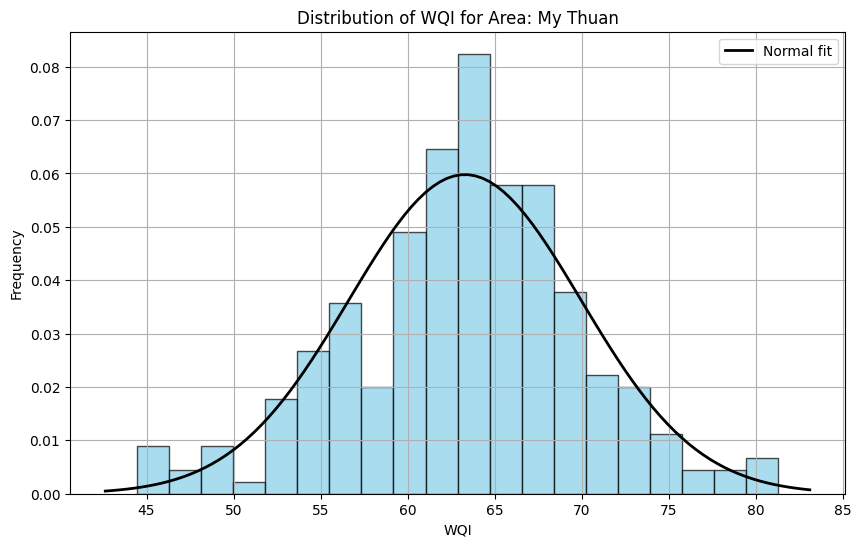

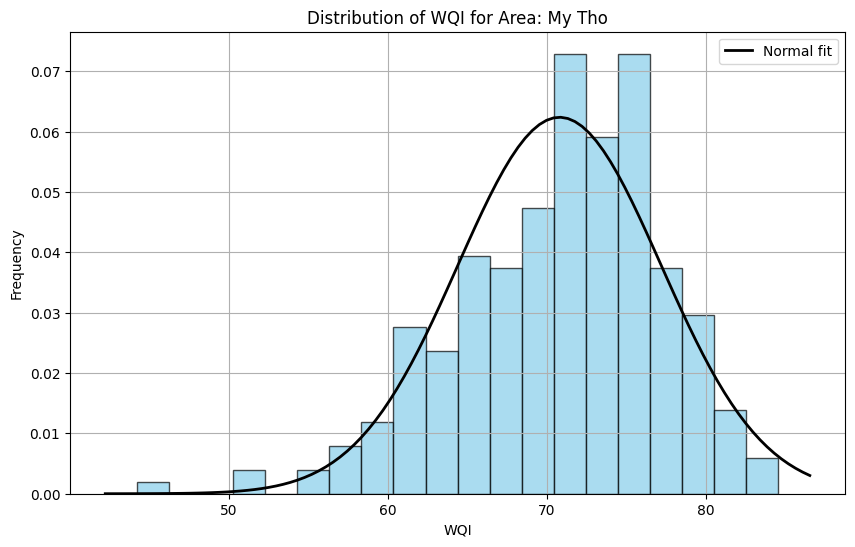

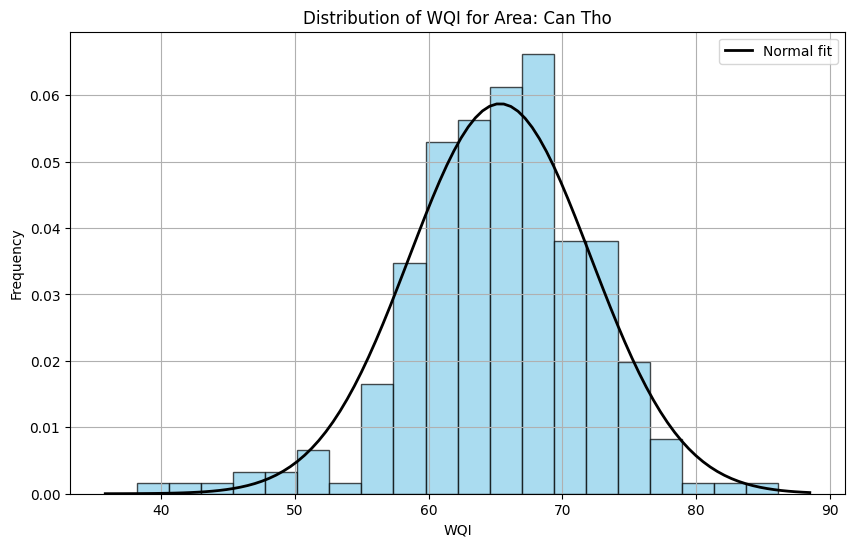

In [83]:
for area in areas:
    area_data = df[df['Area'] == area]

    plt.figure(figsize=(10, 6))

    # Vẽ histogram
    plt.hist(area_data['WQI'], bins=20, color='skyblue', edgecolor='black', density=True, alpha=0.7)

    # Thêm đường phân phối chuẩn
    mu, std = stats.norm.fit(area_data['WQI'])  # Ước tính các tham số của phân phối chuẩn (mean, std)
    xmin, xmax = plt.xlim()  # Lấy phạm vi của trục x
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)  # Tính giá trị của hàm mật độ xác suất (PDF) cho phân phối chuẩn
    plt.plot(x, p, 'k', linewidth=2, label='Normal fit')  # Vẽ đường chuẩn

    # Thêm nhãn và tiêu đề
    plt.title(f'Distribution of WQI for Area: {area}')
    plt.xlabel('WQI')
    plt.ylabel('Frequency')

    # Hiển thị lưới và chú giải
    plt.grid(True)
    plt.legend()

    # Hiển thị đồ thị
    plt.show()

In [84]:
# Kiểm tra tính ổn định (stationarity) của WQI cho từng khu vực
for area in areas:
    area_data = df[df['Area'] == area]
    result = adfuller(area_data['WQI'].dropna())  # Loại bỏ giá trị thiếu nếu có
    print(f"ADF Statistic for {area}: {result[0]}")
    print(f"p-value for {area}: {result[1]}")

    if result[1] < 0.05:
        print(f"Chuỗi thời gian của {area} là ổn định.")
    else:
        print(f"Chuỗi thời gian của {area} không ổn định, cần thực hiện differencing.")
    print("\n")


ADF Statistic for My Thuan: -6.9233972983498795
p-value for My Thuan: 1.131301800679516e-09
Chuỗi thời gian của My Thuan là ổn định.


ADF Statistic for My Tho: -6.671875344013278
p-value for My Tho: 4.566170501332882e-09
Chuỗi thời gian của My Tho là ổn định.


ADF Statistic for Can Tho: -6.73075317720694
p-value for Can Tho: 3.300761166591948e-09
Chuỗi thời gian của Can Tho là ổn định.




## Handle missing values

In [85]:
df.isnull().sum()

,0
Area,0
Date,0
Temperature,0
PH,0
DO,0
pH_score,0
DO_score,0
Temperature_score,0
WQI,0


#Check trend or seasonality

<Figure size 1400x600 with 0 Axes>

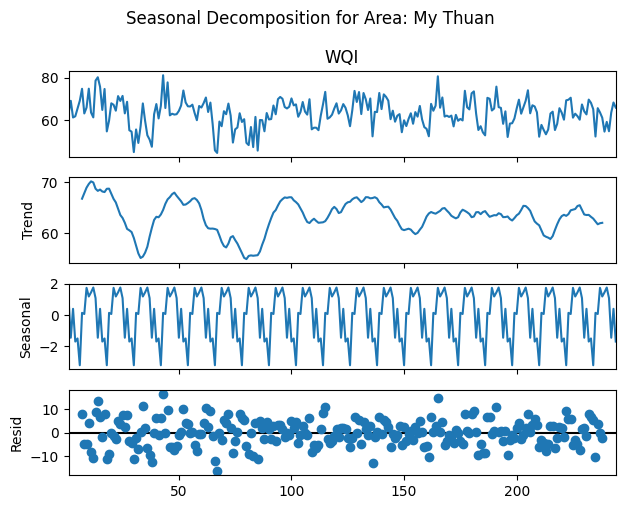

<Figure size 1400x600 with 0 Axes>

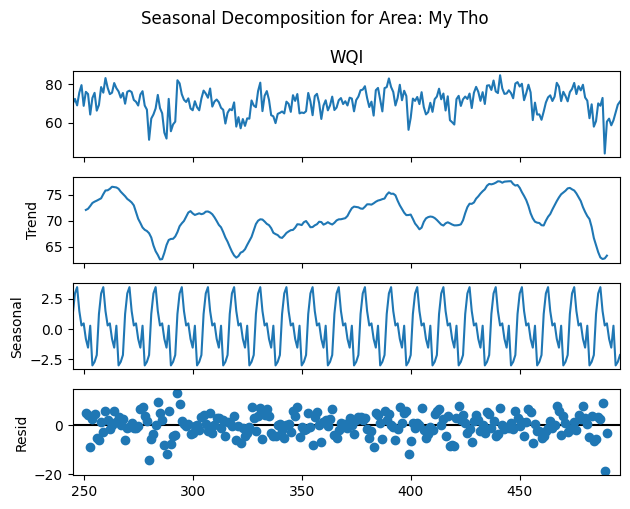

<Figure size 1400x600 with 0 Axes>

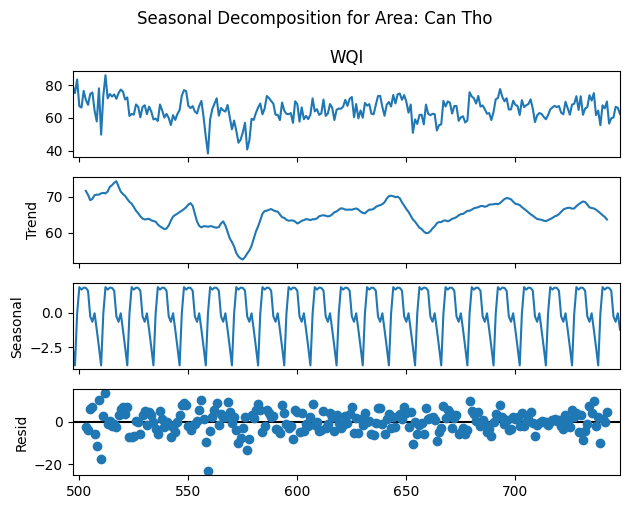

In [86]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

areas = df['Area'].unique()

for area in areas:
    area_data = df[df['Area'] == area]

    # Thực hiện phân tích mùa vụ cho cột 'WQI'
    result = seasonal_decompose(area_data['WQI'], model='additive', period=12)

    # Đặt kích thước cho hình vẽ trước khi plot
    plt.figure(figsize=(14, 6))

    # Vẽ đồ thị phân tích mùa vụ
    result.plot()

    # Đặt tiêu đề cho biểu đồ
    plt.suptitle(f"Seasonal Decomposition for Area: {area}\n", y=1.05)

    # Hiển thị đồ thị
    plt.show()


<ipython-input-87-d4a2330122bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data['WQI_MA'] = area_data['WQI'].rolling(window=12).mean()


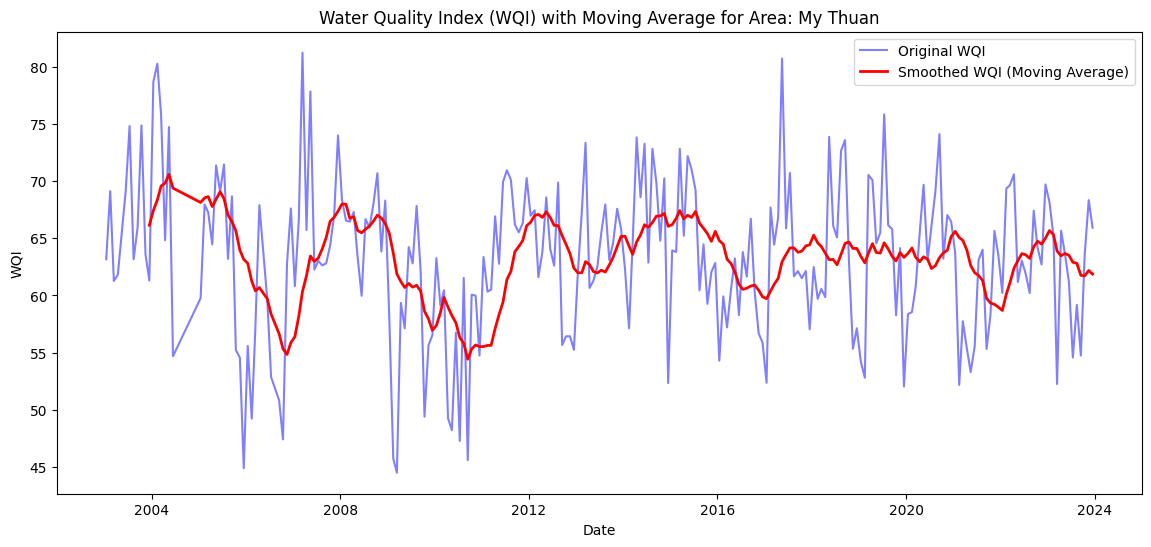

<ipython-input-87-d4a2330122bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data['WQI_MA'] = area_data['WQI'].rolling(window=12).mean()


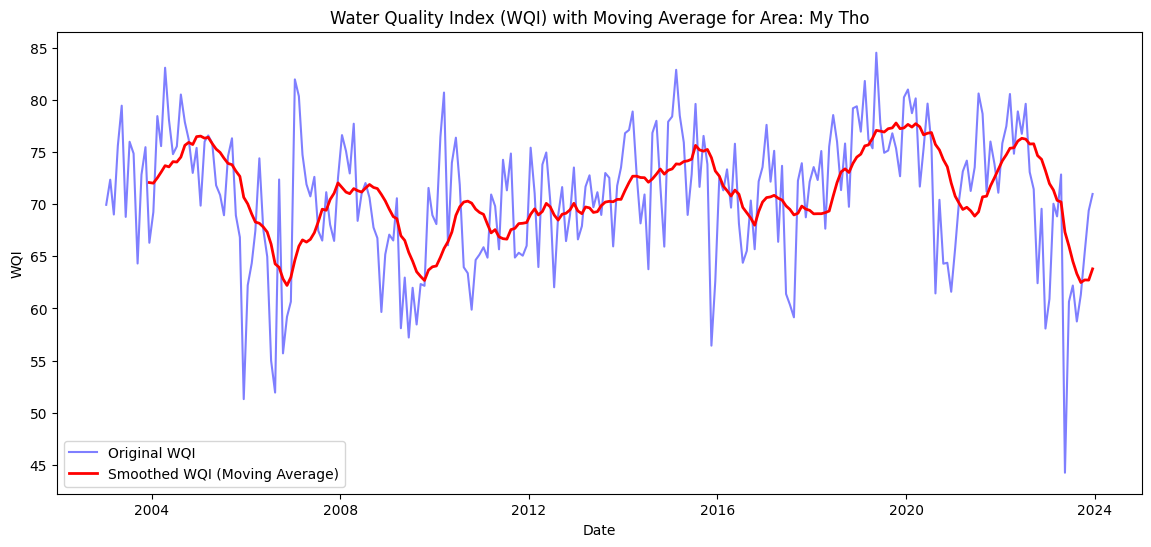

<ipython-input-87-d4a2330122bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data['WQI_MA'] = area_data['WQI'].rolling(window=12).mean()


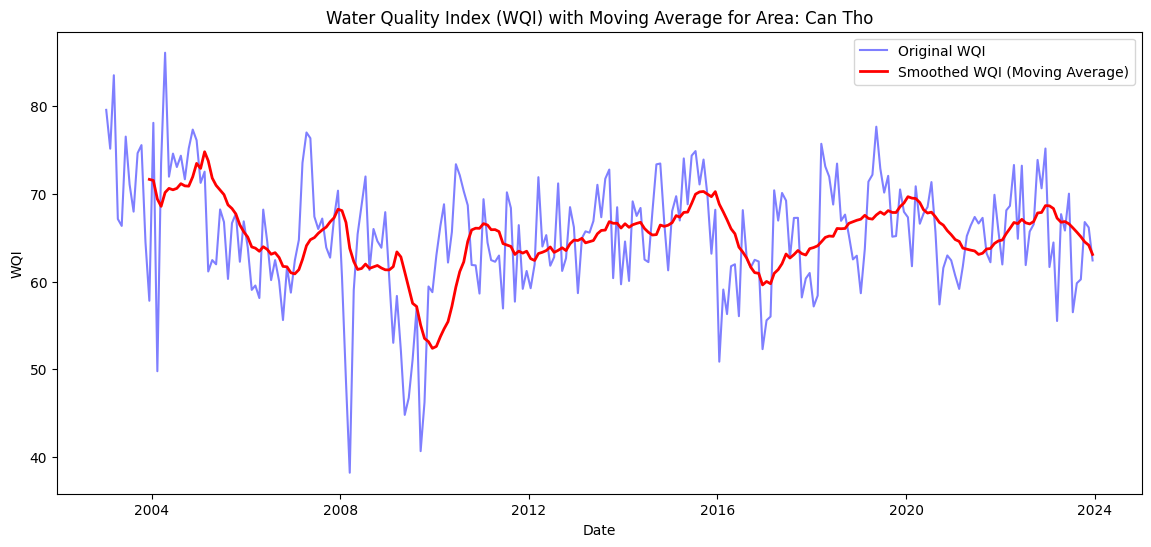

In [87]:
# Tính Moving Average (chu kỳ 12 tháng) cho từng khu vực
for area in areas:
    area_data = df[df['Area'] == area]

    # Tính Moving Average cho WQI
    area_data['WQI_MA'] = area_data['WQI'].rolling(window=12).mean()

    # Vẽ biểu đồ WQI gốc và WQI sau khi làm mượt cho từng khu vực
    plt.figure(figsize=(14, 6))
    plt.plot(area_data['Date'], area_data['WQI'], label='Original WQI', color='blue', alpha=0.5)
    plt.plot(area_data['Date'], area_data['WQI_MA'], label='Smoothed WQI (Moving Average)', color='red', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('WQI')
    plt.title(f'Water Quality Index (WQI) with Moving Average for Area: {area}')
    plt.legend()
    plt.show()


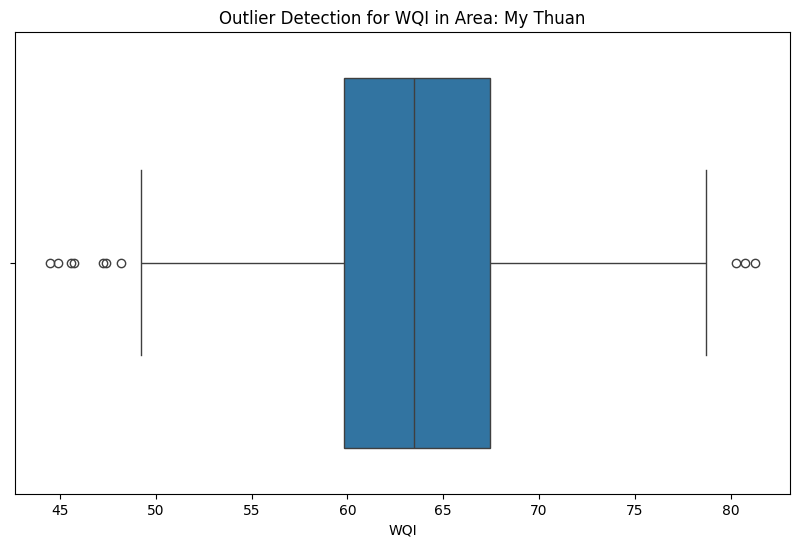

<ipython-input-88-2b116d12e48f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data['WQI_capped'] = area_data['WQI'].clip(lower=40, upper=90)


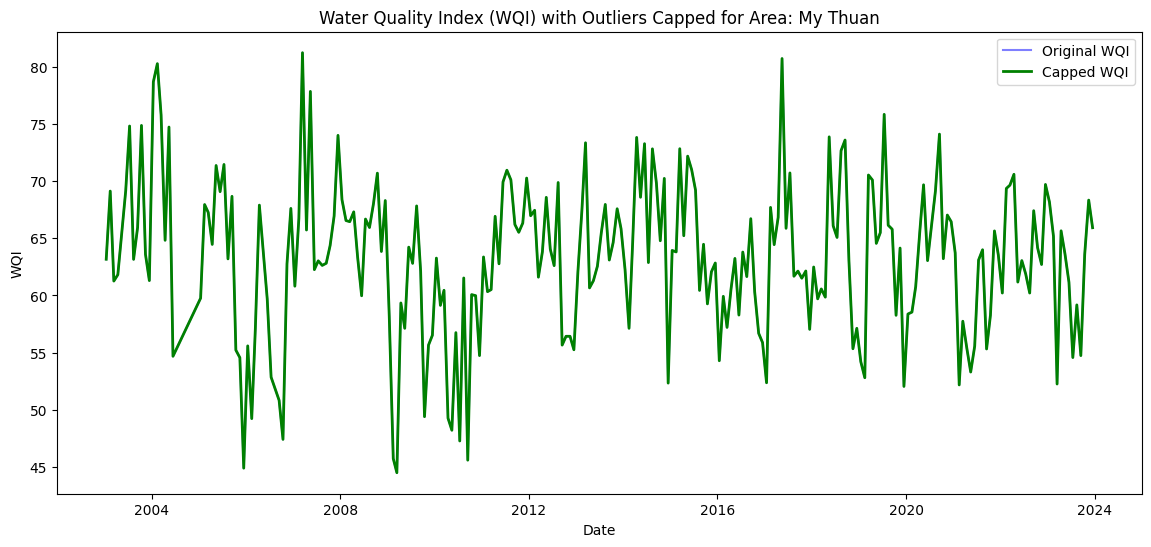

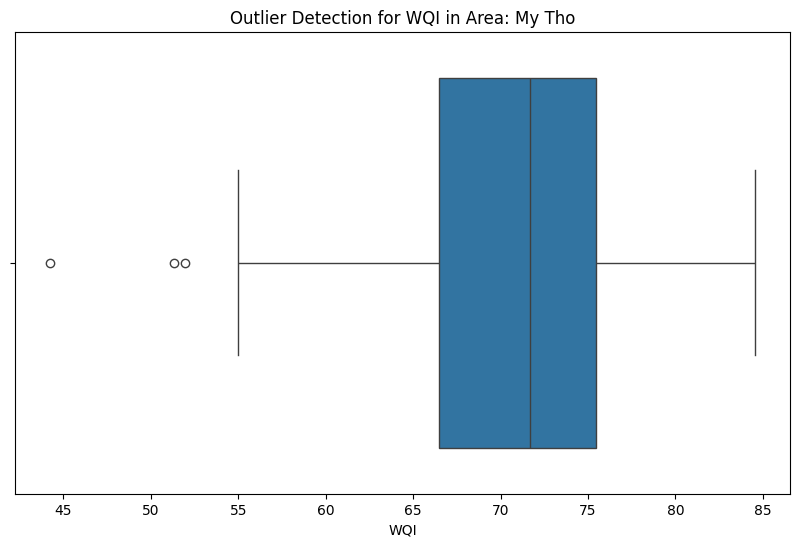

<ipython-input-88-2b116d12e48f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data['WQI_capped'] = area_data['WQI'].clip(lower=40, upper=90)


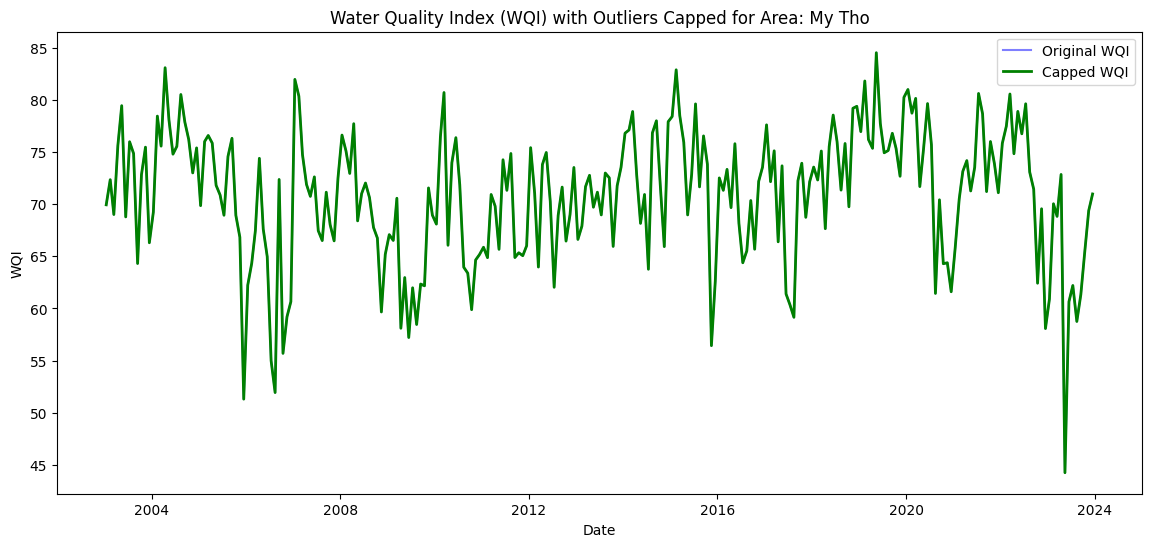

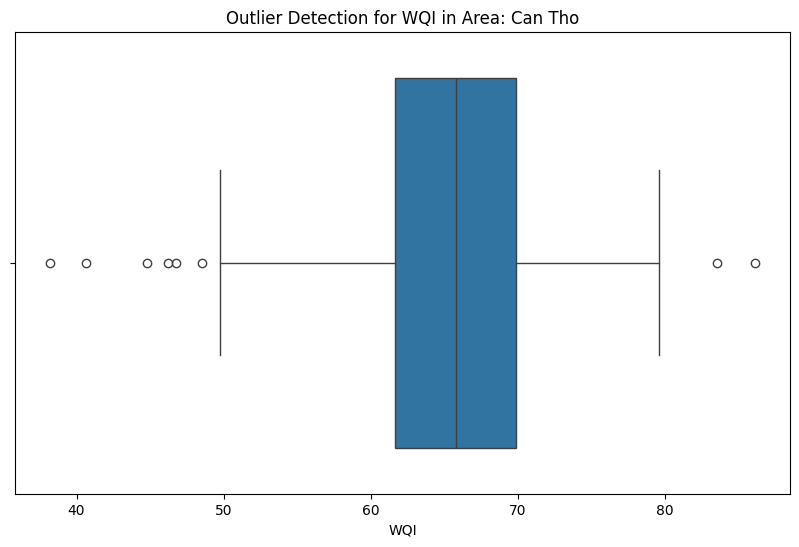

<ipython-input-88-2b116d12e48f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_data['WQI_capped'] = area_data['WQI'].clip(lower=40, upper=90)


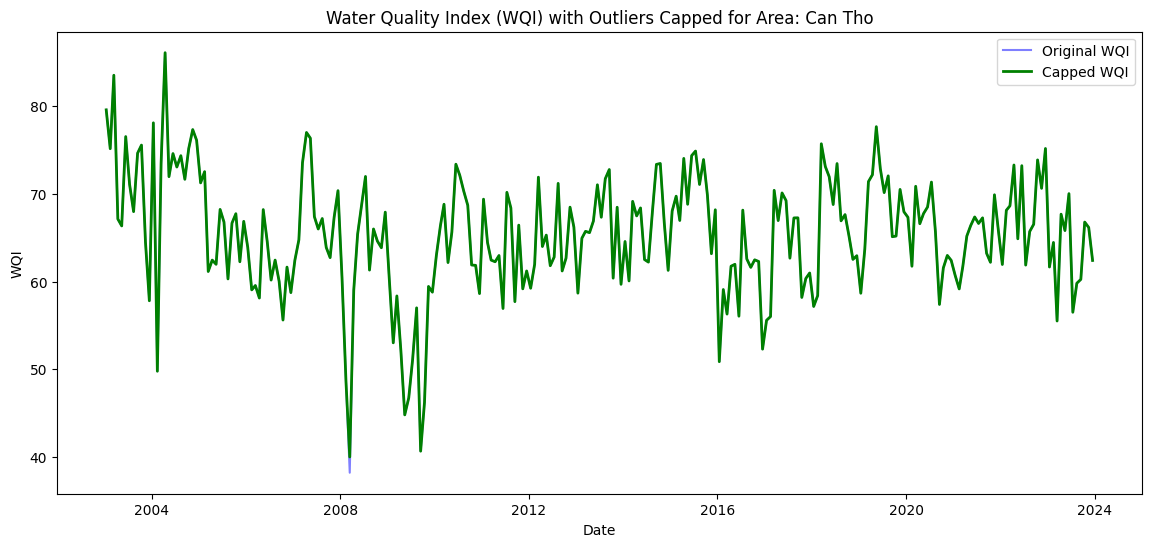

In [88]:
# Vẽ boxplot để phát hiện ngoại lai cho từng khu vực
for area in areas:
    area_data = df[df['Area'] == area]

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=area_data['WQI'])
    plt.title(f'Outlier Detection for WQI in Area: {area}')
    plt.show()

    # Capping ngoại lai: Giới hạn WQI trong phạm vi hợp lý (ví dụ: từ 40 đến 90)
    area_data['WQI_capped'] = area_data['WQI'].clip(lower=40, upper=90)

    # Vẽ lại dữ liệu sau khi capping
    plt.figure(figsize=(14, 6))
    plt.plot(area_data['Date'], area_data['WQI'], label='Original WQI', color='blue', alpha=0.5)
    plt.plot(area_data['Date'], area_data['WQI_capped'], label='Capped WQI', color='green', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('WQI')
    plt.title(f'Water Quality Index (WQI) with Outliers Capped for Area: {area}')
    plt.legend()
    plt.show()


In [112]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [113]:
for i in range(1, 13):  # 12 tháng
    df[f'WQI_t-{i}'] = df['WQI'].shift(i)


In [114]:
le = LabelEncoder()
df['Area'] = le.fit_transform(df['Area'])

In [115]:
# Kiểm tra các giá trị null trong toàn bộ DataFrame
df.dropna(inplace=True)

In [93]:
X = df.drop(['Date', 'WQI'], axis=1)
y = df['WQI']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80% huấn luyện, 20% kiểm tra)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Huấn luyện mô hình Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Dự đoán
rf_predictions = rf.predict(X_test)

# Tính Mean Squared Error (MSE)
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest Mean Squared Error: {rf_mse}")

# Huấn luyện mô hình XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Dự đoán
xgb_predictions = xgb.predict(X_test)

# Tính Mean Squared Error (MSE)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print(f"XGBoost Mean Squared Error: {xgb_mse}")

Random Forest Mean Squared Error: 4.252497839324321
XGBoost Mean Squared Error: 4.849478359069428


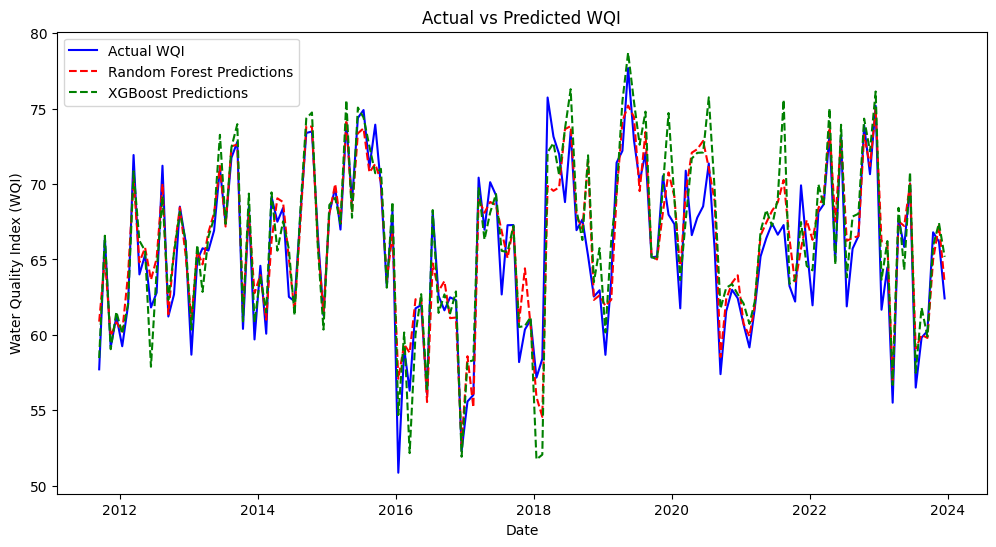

In [95]:
# Lấy cột 'Date' tương ứng với y_test
dates_test = df.loc[y_test.index, 'Date']

# Vẽ đồ thị với DateTime làm trục x
plt.figure(figsize=(12, 6))

plt.plot(dates_test, y_test, label='Actual WQI', color='blue')  # Actual WQI (Dữ liệu thực tế)
plt.plot(dates_test, rf_predictions, label='Random Forest Predictions', linestyle='--', color='red')  # Dự đoán Random Forest
plt.plot(dates_test, xgb_predictions, label='XGBoost Predictions', linestyle='--', color='green')  # Dự đoán XGBoost

# Thêm tên trục và tiêu đề
plt.xlabel('Date')  # Trục x là DateTime
plt.ylabel('Water Quality Index (WQI)')  # Trục y là WQI
plt.title('Actual vs Predicted WQI')  # Tiêu đề đồ thị

# Thêm chú thích cho đồ thị
plt.legend()

# Hiển thị đồ thị
plt.show()


In [116]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_grid_search = GridSearchCV(RandomForestRegressor(), param_grid=rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
print("Best Parameters for RandomForest:", rf_grid_search.best_params_)

# XGBoost Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_grid_search = GridSearchCV(XGBRegressor(), param_grid=xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)
print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Best Parameters for RandomForest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}


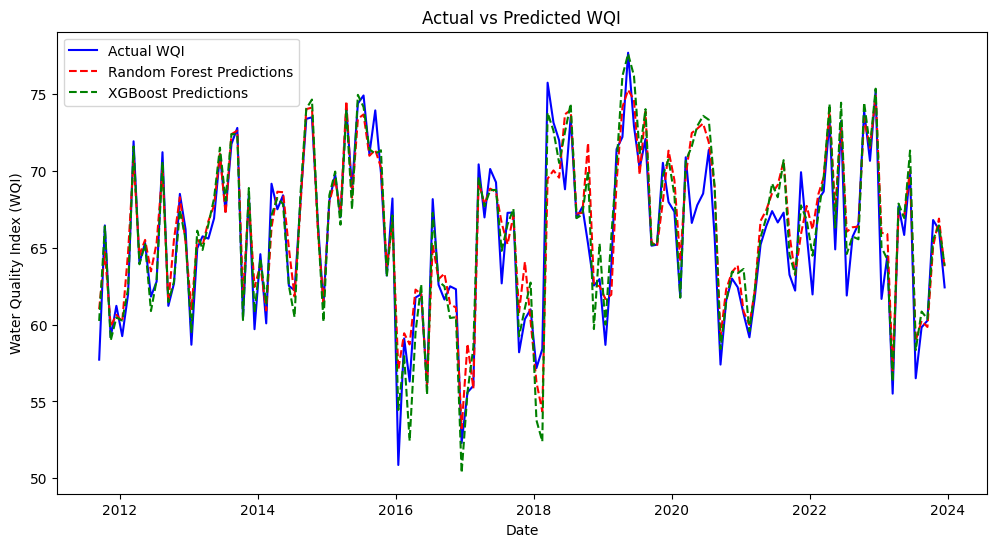

In [117]:
# Lấy cột 'Date' tương ứng với y_test
dates_test = df.loc[y_test.index, 'Date']

# Vẽ đồ thị với DateTime làm trục x
plt.figure(figsize=(12, 6))

plt.plot(dates_test, y_test, label='Actual WQI', color='blue')  # Actual WQI (Dữ liệu thực tế)
plt.plot(dates_test, rf_predictions, label='Random Forest Predictions', linestyle='--', color='red')  # Dự đoán Random Forest
plt.plot(dates_test, xgb_predictions, label='XGBoost Predictions', linestyle='--', color='green')  # Dự đoán XGBoost

# Thêm tên trục và tiêu đề
plt.xlabel('Date')  # Trục x là DateTime
plt.ylabel('Water Quality Index (WQI)')  # Trục y là WQI
plt.title('Actual vs Predicted WQI')  # Tiêu đề đồ thị

# Thêm chú thích cho đồ thị
plt.legend()

# Hiển thị đồ thị
plt.show()


In [118]:
from sklearn.model_selection import cross_val_score

# Cross-Validation cho Random Forest
rf_cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest Cross-Validation MSE: {rf_cv_scores.mean()}")

# Cross-Validation cho XGBoost
xgb_cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"XGBoost Cross-Validation MSE: {xgb_cv_scores.mean()}")


Random Forest Cross-Validation MSE: -8.515580744387163
XGBoost Cross-Validation MSE: -5.0323284739153085


In [119]:
rf_best = RandomForestRegressor(**rf_grid_search.best_params_)
rf_best.fit(X_train, y_train)
rf_best_predictions = rf_best.predict(X_test)
rf_best_mse = mean_squared_error(y_test, rf_best_predictions)
print(f"Random Forest Optimized MSE: {rf_best_mse}")

xgb_best = XGBRegressor(**xgb_grid_search.best_params_)
xgb_best.fit(X_train, y_train)
xgb_best_predictions = xgb_best.predict(X_test)
xgb_best_mse = mean_squared_error(y_test, xgb_best_predictions)
print(f"XGBoost Optimized MSE: {xgb_best_mse}")


Random Forest Optimized MSE: 5.261671898276623
XGBoost Optimized MSE: 1.1700414498828715


In [120]:
rf_best_cv_scores = cross_val_score(rf_best, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Optimized Random Forest Cross-Validation MSE: {rf_best_cv_scores.mean()}")

xgb_best_cv_scores = cross_val_score(xgb_best, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Optimized XGBoost Cross-Validation MSE: {xgb_best_cv_scores.mean()}")


Optimized Random Forest Cross-Validation MSE: -10.98147682702368
Optimized XGBoost Cross-Validation MSE: -3.5013871437066912


In [121]:
rf_r2 = r2_score(y_test, rf_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)
print(f"Random Forest R²: {rf_r2}")
print(f"XGBoost R²: {xgb_r2}")

Random Forest R²: 0.8426042117286043
XGBoost R²: 0.8912012919376522


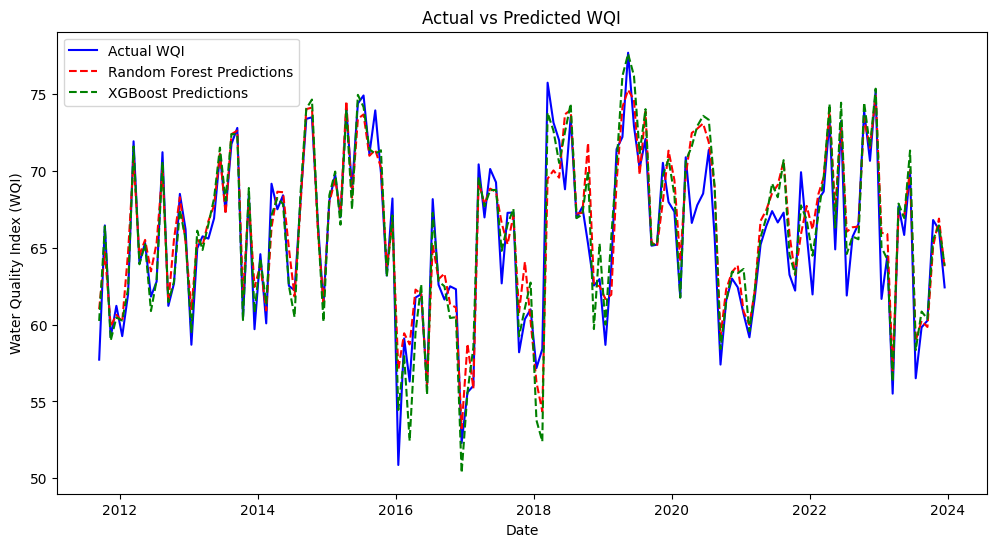

In [122]:
# Lấy cột 'Date' tương ứng với y_test
dates_test = df.loc[y_test.index, 'Date']

# Vẽ đồ thị với DateTime làm trục x
plt.figure(figsize=(12, 6))

plt.plot(dates_test, y_test, label='Actual WQI', color='blue')  # Actual WQI (Dữ liệu thực tế)
plt.plot(dates_test, rf_predictions, label='Random Forest Predictions', linestyle='--', color='red')  # Dự đoán Random Forest
plt.plot(dates_test, xgb_predictions, label='XGBoost Predictions', linestyle='--', color='green')  # Dự đoán XGBoost

# Thêm tên trục và tiêu đề
plt.xlabel('Date')  # Trục x là DateTime
plt.ylabel('Water Quality Index (WQI)')  # Trục y là WQI
plt.title('Actual vs Predicted WQI')  # Tiêu đề đồ thị

# Thêm chú thích cho đồ thị
plt.legend()

# Hiển thị đồ thị
plt.show()
